# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [8]:
from maddpg import Maddpg
from collections import deque
import torch

def train(n_episodes=10000, max_t=1000, print_every=100):
    # Seed & random noise
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    noise = NOISE
    
    # Instantiate MADDPG agents
    maddpg = Maddpg(state_size, action_size, num_agents, SEED)

    # Scores
    scores_deque = deque(maxlen=100)
    scores, avg_scores = [], []
    
    # Training Loop
    for i_episode in range(n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        maddpg.reset()                                             # reset the agents 
            
        states = env_info.vector_observations                      # get the current state for each agent 
        agents_scores = np.zeros(num_agents)                       # initialize the score (for each agent)

        for steps in range(max_t):
            actions = maddpg.act(states, noise)                    # retrieve actions to performe for each agents 
            noise *= NOISE_REDUCTION                               # Decrease action noise
            env_info = env.step({brain_name: [actions]})[brain_name] # send all actions to the environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            # Save experience in replay memory, and use random sample from buffer to learn
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)
            agents_scores += env_info.rewards                      # update the score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
        
        score  = np.max(agents_scores)
        scores.append(score)
        scores_deque.append(score)
        avg_score = np.mean(scores_deque) # Compute average score over last 100 episodes

        # Display learning statistics 
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode score (max over agents): {:.2f}'.format(i_episode, avg_score, score), end="")
        if i_episode>0 and i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tnoise={:.4f}'.format(i_episode, avg_score, noise))
            avg_scores.append(avg_score)
            maddpg.save()
            
        # Early stopping when the environment is deemed solved
        if (i_episode > 99) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            maddpg.save()
            return scores
    return scores

In [9]:
# Launch training
scores = train()

Episode 100	Average Score: 0.00	noise=1.0000e (max over agents): 0.00
Episode 200	Average Score: 0.01	noise=1.0000e (max over agents): 0.00
Episode 300	Average Score: 0.00	noise=1.0000e (max over agents): 0.00
Episode 400	Average Score: 0.00	noise=1.0000e (max over agents): 0.00
Episode 500	Average Score: 0.00	noise=1.0000e (max over agents): 0.00
Episode 600	Average Score: 0.01	noise=1.0000e (max over agents): 0.00
Episode 700	Average Score: 0.01	noise=1.0000e (max over agents): 0.00
Episode 800	Average Score: 0.01	noise=1.0000e (max over agents): 0.00
Episode 900	Average Score: 0.02	noise=1.0000e (max over agents): 0.09
Episode 1000	Average Score: 0.03	noise=1.0000e (max over agents): 0.00
Episode 1100	Average Score: 0.03	noise=1.0000e (max over agents): 0.00
Episode 1200	Average Score: 0.06	noise=1.0000e (max over agents): 0.00
Episode 1300	Average Score: 0.07	noise=1.0000e (max over agents): 0.19
Episode 1400	Average Score: 0.09	noise=1.0000e (max over agents): 0.00
Episode 1500	Av

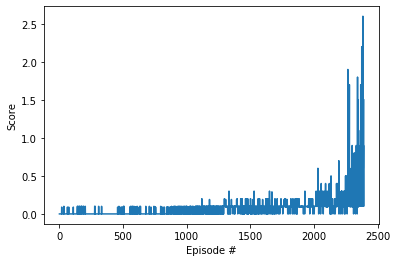

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [11]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```